Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('uber.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


 ## 1. Pre-process the dataset.

In [3]:
df.shape

(200000, 9)

In [4]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
df.isnull()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
199995,False,False,False,False,False,False,False,False,False
199996,False,False,False,False,False,False,False,False,False
199997,False,False,False,False,False,False,False,False,False
199998,False,False,False,False,False,False,False,False,False


In [6]:
df.drop(columns=["Unnamed: 0", "key"], inplace=True)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [7]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [8]:
df['dropoff_latitude'].fillna(value=df['dropoff_latitude'].mean(),inplace = True)
df['dropoff_longitude'].fillna(value=df['dropoff_longitude'].median(),inplace = True)

In [9]:
df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [10]:
# From the above output, we see that the data type of 'pickup_datetime' is 'object
# But 'pickup_datetime'is a date time stamp variable, which is wrongly interpreted as 'object', so we will convert this variable data type to 'datetime'.

In [11]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [12]:
# we will extract time feature from the 'pickup_datetime' 
# we will add a variable which measures the distance between pickup and drop

In [13]:
df = df.assign(hour = df.pickup_datetime.dt.hour,
               day = df.pickup_datetime.dt.day,
               month = df.pickup_datetime.dt.month,
               year = df.pickup_datetime.dt.year,
               dayofweek = df.pickup_datetime.dt.dayofweek)

In [14]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,10,28,10,2012,6
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1,14,3,2014,4
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0,29,6,2009,0
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14,20,5,2015,2


In [15]:
df = df.drop(["pickup_datetime"], axis =1)
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,10,28,10,2012,6
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,1,14,3,2014,4
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,0,29,6,2009,0
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,14,20,5,2015,2


In [16]:
# function to calculate the travel distance from the longitudes and latitudes
from math import *
    
def distance_formula(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range (len(longitude1)):
        lon1, lan1, lon2, lan2 = map(radians, [longitude1[pos], latitude1[pos], longitude2[pos], latitude2[pos]])
        dist_lon = lon2 - lon1
        dist_lan = lan2 - lan1
        
        a = sin(dist_lan/2)**2 + cos(lan1) * cos(lan2) * sin(dist_lon/2)**2
        
        #radius of earth = 6371
        c = 2 * asin(sqrt(a)) * 6371 
        travel_dist.append(c)
            
    return  travel_dist

In [17]:
df['dist_travel_km'] = distance_formula(df.pickup_longitude.to_numpy(), df.pickup_latitude.to_numpy(), df.dropoff_longitude.to_numpy(), df.dropoff_latitude.to_numpy())

## 2. Identify outliers.

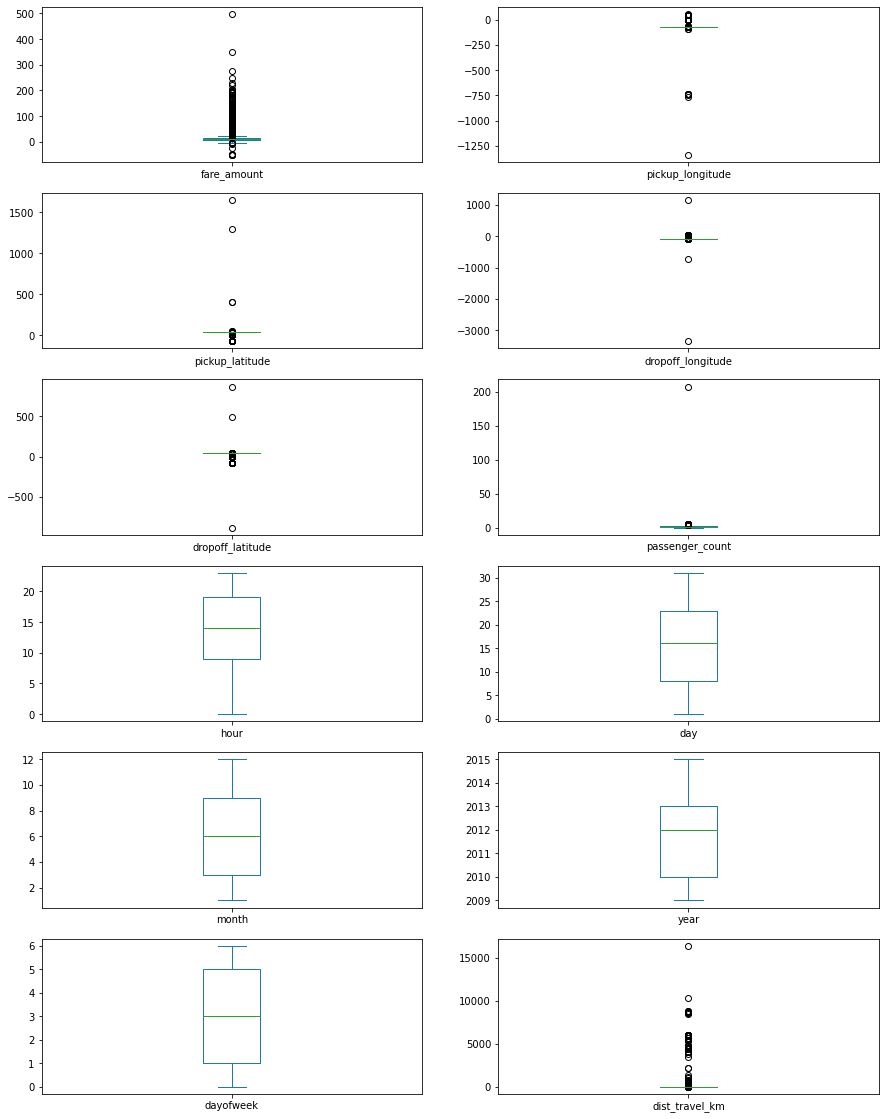

In [18]:
df.plot(kind = "box",subplots = True,layout = (6,2),figsize=(15,20)) #Boxplot to check the outliers
plt.show()

In [19]:
#Using the InterQuartile Range to fill the values
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1

def treat_outliers_all(df1 , col_list):
    for c in col_list:
        df1 = remove_outlier(df , c)
    return df1

In [20]:
df = treat_outliers_all(df , df.iloc[: , 0::])

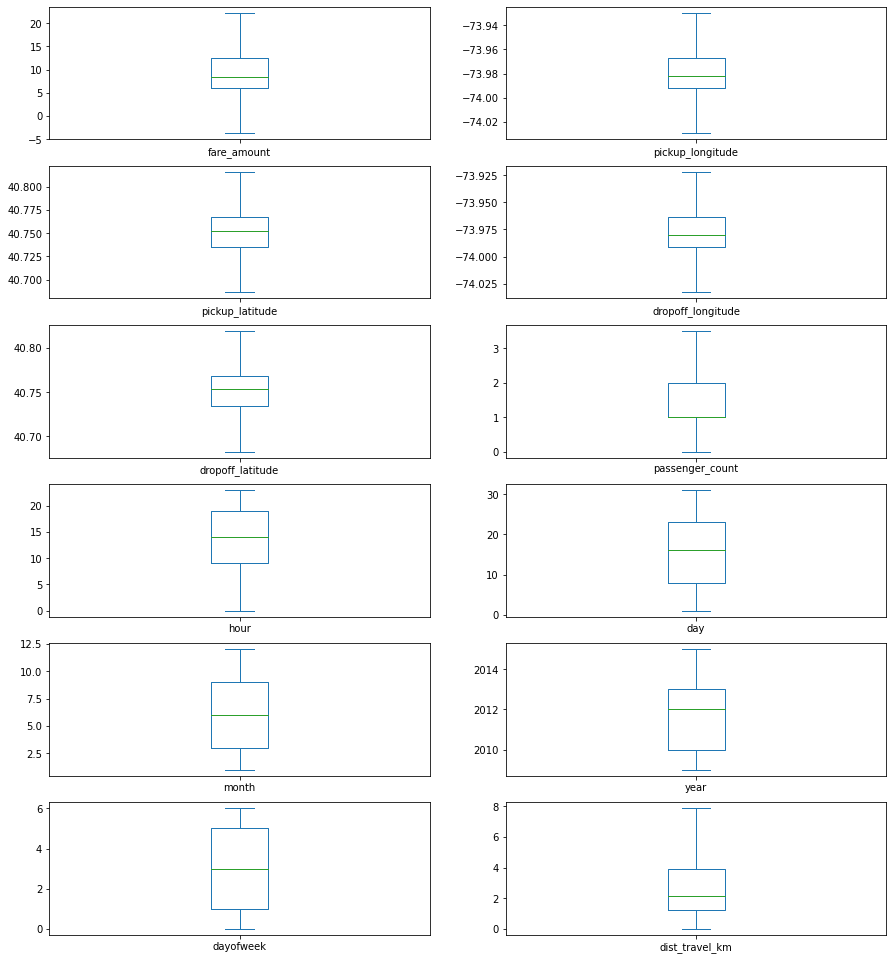

In [21]:
#Boxplot shows that dataset is free from outliers
df.plot(kind = "box",subplots = True,layout = (7,2),figsize=(15,20)) 
plt.show()

## 3. Check the correlation.

In [22]:
#Function to find the correlation
corr = df.corr() 
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
fare_amount,1.000000,0.154069,-0.110842,0.218675,-0.125898,0.015778,-0.023623,0.004534,0.030817,0.141277,0.013652,0.844374
pickup_longitude,0.154069,1.000000,0.259497,0.425619,0.073290,-0.013213,0.011579,-0.003204,0.001169,0.010198,-0.024652,0.098094
pickup_latitude,-0.110842,0.259497,1.000000,0.048889,0.515714,-0.012889,0.029681,-0.001553,0.001562,-0.014243,-0.042310,-0.046812
dropoff_longitude,0.218675,0.425619,0.048889,1.000000,0.245667,-0.009303,-0.046558,-0.004007,0.002391,0.011346,-0.003336,0.186531
dropoff_latitude,-0.125898,0.073290,0.515714,0.245667,1.000000,-0.006308,0.019783,-0.003479,-0.001193,-0.009603,-0.031919,-0.038900
passenger_count,0.015778,-0.013213,-0.012889,-0.009303,-0.006308,1.000000,0.020274,0.002712,0.010351,-0.009749,0.048550,0.009709
hour,-0.023623,0.011579,0.029681,-0.046558,0.019783,0.020274,1.000000,0.004677,-0.003926,0.002156,-0.086947,-0.038366
day,0.004534,-0.003204,-0.001553,-0.004007,-0.003479,0.002712,0.004677,1.000000,-0.017360,-0.012170,0.005617,0.003062
month,0.030817,0.001169,0.001562,0.002391,-0.001193,0.010351,-0.003926,-0.017360,1.000000,-0.115859,-0.008786,0.011628
year,0.141277,0.010198,-0.014243,0.011346,-0.009603,-0.009749,0.002156,-0.012170,-0.115859,1.000000,0.006113,0.024278


<AxesSubplot:>

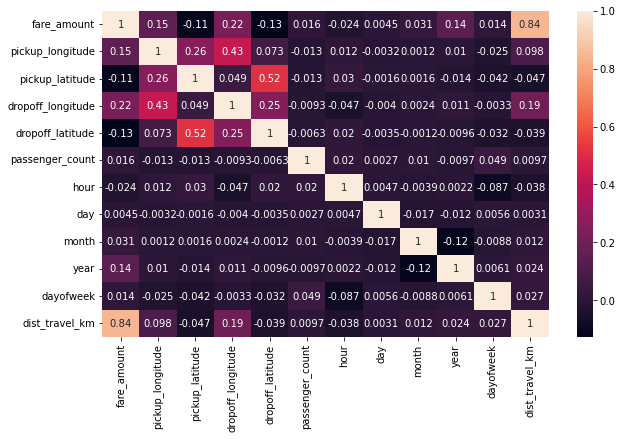

In [23]:
fig,axis = plt.subplots(figsize = (10,6))
sns.heatmap(df.corr(),annot = True) #Correlation Heatmap (Light values means highly correlated)

## 4. Implement linear regression and random forest regression models.

In [24]:
# Dividing the dataset into feature and target values 
# df_x = df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','hour','day','month','year','dayofweek','dist_travel_km']]

df_x = df[['dist_travel_km']]
df_y = df['fare_amount']

In [25]:
# Dividing the dataset into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(df_x.values, df_y, test_size=0.2, random_state=1)

In [26]:
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,7.50,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683323
1,7.70,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457590
2,12.90,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036377
3,5.30,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661683
4,16.00,-73.929786,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.475450
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.00,-73.987042,40.739367,-73.986525,40.740297,1.0,10,28,10,2012,6,0.112210
199996,7.50,-73.984722,40.736837,-74.006672,40.739620,1.0,1,14,3,2014,4,1.875050
199997,22.25,-73.986017,40.756487,-73.922036,40.692588,2.0,0,29,6,2009,0,7.865286
199998,14.50,-73.997124,40.725452,-73.983215,40.695415,1.0,14,20,5,2015,2,3.539715


In [27]:
from sklearn.linear_model import LinearRegression

# initialize the linear regression model
reg = LinearRegression()

# Train the model with our training data
reg.fit(x_train, y_train)

LinearRegression()

In [28]:
y_pred_lin = reg.predict(x_test)
print(y_pred_lin)

[ 5.21435668  6.2610365   8.55455988 ... 10.64189609 12.3824025
 11.96786543]


In [29]:
from sklearn.ensemble import RandomForestRegressor

#Here n_estimators means number of trees you want to build before making the prediction
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train,y_train)

RandomForestRegressor()

In [30]:
y_pred_rf = rf.predict(x_test)
print(y_pred_rf)

[ 4.316  8.549  8.896 ... 13.302 13.827 11.017]


## 5. Evaluate the models and compare their respective scores like R2, RMSE, etc

In [31]:
cols = ['Model', 'RMSE', 'R-Squared']

# create a empty dataframe of the colums
# columns: specifies the columns to be selected
result_tabulation = pd.DataFrame(columns = cols)

In [32]:
from sklearn import metrics 
from sklearn.metrics import r2_score 

reg_MSE = metrics.mean_squared_error(y_test,y_pred_lin)
reg_MAE = metrics.mean_absolute_error(y_test,y_pred_lin)
reg_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin))
reg_squared = r2_score(y_test, y_pred_lin)

full_metrics = pd.Series({'Model': "Linear Regression", 'RMSE' : reg_RMSE,'MSE' : reg_MSE, 'RMAE' : reg_MAE, 'R-Squared' : reg_squared})

# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation.append(full_metrics, ignore_index = True)

# print the result table
result_tabulation

rf_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
rf_squared = r2_score(y_test, y_pred_rf)
rf_MSE = metrics.mean_squared_error(y_test,y_pred_rf)
rf_MAE = metrics.mean_absolute_error(y_test,y_pred_rf)

full_metrics = pd.Series({'Model': "Random Forest ",'MSE' : rf_MSE, 'RMAE' : rf_MAE,'RMSE':rf_RMSE, 'R-Squared': rf_squared})
# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation.append(full_metrics, ignore_index = True)

# print the result table
result_tabulation


,Model,RMSE,R-Squared,MSE,RMAE
0,Linear Regression,2.898517,0.717217,8.401402,1.972447
1,Random Forest,3.142285,0.667653,9.873956,2.146196


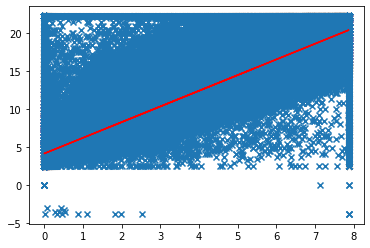

In [33]:
y_reg_line = reg.predict(df_x)
plt.scatter(df_x,df_y,marker='x')
plt.plot(df_x,y_reg_line,color='red')

In [34]:
input_dist = float(input("Enter distance travelled in KM: "))
input_arr = np.array([input_dist])
input_arr = input_arr.reshape(1,-1)
input_y_pred = reg.predict(input_arr)

print("Your Estimated fare: ", input_y_pred)

Enter distance travelled in KM: 2
Your Estimated fare:  [8.31669728]
